# 문제 1

In [1]:
import torch
from torchvision import datasets, transforms

# Fashion MNIST 데이터 로드
data_path = "./fashion_mnist_data"
f_mnist_train = datasets.FashionMNIST(
    data_path, train=True, download=True, transform=transforms.ToTensor()
)

# 모든 데이터를 하나의 텐서로 합치기
train_loader = torch.utils.data.DataLoader(f_mnist_train, batch_size=len(f_mnist_train))
data = next(iter(train_loader))[0]  # 전체 이미지 데이터 (shape: [60000, 1, 28, 28])

# 데이터의 평균과 표준편차 계산
mean = data.mean().item()
std = data.std().item()

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: 0.28604060411453247
Std: 0.3530242443084717


# 문제 2

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
from torchinfo import summary

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 변환 정의 (Mean과 Std 적용)
mean, std = 0.28604060411453247, 0.3530242443084717
f_mnist_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# 데이터셋 로드 및 분할
data_path = "./fashion_mnist_data"
train_val_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=f_mnist_transforms)
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=f_mnist_transforms)

train_dataset, val_dataset = random_split(train_val_dataset, [55000, 5000])  # 학습/검증 데이터 분할
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv2D + MaxPool2D 출력 크기 계산
        self.flatten_dim = 64 * 7 * 7  # (64 채널, 7x7 크기)

        self.fc1 = nn.Linear(self.flatten_dim, 128)  # 입력 크기 수정
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # 플래튼
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 모델 정의 및 구조 출력
model = SimpleCNN().to(device)
print(summary(model, input_size=(256, 1, 28, 28)))

# 학습 파라미터 설정
num_epochs = 200
early_stop_patience = 20
learning_rate = 0.00056

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# WandB 초기화
wandb.init(project="fashion_mnist", config={
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": 256
})

# 학습 루프
best_val_accuracy = 0.0
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\n# 학습 단계: Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    train_accuracy = 100.0 * correct_train / total_train
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # 검증 단계
    print("# 검증 단계 시작")
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    val_accuracy = 100.0 * correct_val / total_val
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # 스케줄러 업데이트
    scheduler.step(val_loss)

    # Early Stopping 조건 확인
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("최적 모델 저장 완료")
    else:
        patience_counter += 1
        print(f"Early Stopping 카운터: {patience_counter}/{early_stop_patience}")
        if patience_counter >= early_stop_patience:
            print("Early Stopping 발생")
            break

    # WandB 기록
    wandb.log({
        "Train Loss": train_loss / len(train_loader),
        "Validation Loss": val_loss / len(val_loader),
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy
    })

# 학습 완료 후 최적 성능 출력
print("\n학습 완료")
print(f"최고 Validation Accuracy: {best_val_accuracy:.2f}%")


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [256, 10]                 --
├─Conv2d: 1-1                            [256, 32, 28, 28]         320
├─BatchNorm2d: 1-2                       [256, 32, 28, 28]         64
├─MaxPool2d: 1-3                         [256, 32, 14, 14]         --
├─Conv2d: 1-4                            [256, 64, 14, 14]         18,496
├─BatchNorm2d: 1-5                       [256, 64, 14, 14]         128
├─MaxPool2d: 1-6                         [256, 64, 7, 7]           --
├─Linear: 1-7                            [256, 128]                401,536
├─Dropout: 1-8                           [256, 128]                --
├─Linear: 1-9                            [256, 10]                 1,290
Total params: 421,834
Trainable params: 421,834
Non-trainable params: 0
Total mult-adds (G): 1.10
Input size (MB): 0.80
Forward/backward pass size (MB): 154.42
Params size (MB): 1.69
Estimated Total Size (MB): 1


# 학습 단계: Epoch 1/200
Train Loss: 0.6115, Train Accuracy: 78.14%
# 검증 단계 시작
Validation Loss: 0.4005, Validation Accuracy: 85.70%
최적 모델 저장 완료

# 학습 단계: Epoch 2/200
Train Loss: 0.4104, Train Accuracy: 85.03%
# 검증 단계 시작
Validation Loss: 0.3547, Validation Accuracy: 87.34%
최적 모델 저장 완료

# 학습 단계: Epoch 3/200
Train Loss: 0.3667, Train Accuracy: 86.78%
# 검증 단계 시작
Validation Loss: 0.3288, Validation Accuracy: 87.98%
최적 모델 저장 완료

# 학습 단계: Epoch 4/200
Train Loss: 0.3467, Train Accuracy: 87.46%
# 검증 단계 시작
Validation Loss: 0.3246, Validation Accuracy: 87.82%
Early Stopping 카운터: 1/20

# 학습 단계: Epoch 5/200
Train Loss: 0.3260, Train Accuracy: 88.22%
# 검증 단계 시작
Validation Loss: 0.3076, Validation Accuracy: 88.68%
최적 모델 저장 완료

# 학습 단계: Epoch 6/200
Train Loss: 0.3103, Train Accuracy: 88.70%
# 검증 단계 시작
Validation Loss: 0.2910, Validation Accuracy: 89.48%
최적 모델 저장 완료

# 학습 단계: Epoch 7/200
Train Loss: 0.3026, Train Accuracy: 89.04%
# 검증 단계 시작
Validation Loss: 0.2823, Validation Accuracy: 90.34%
최적 모델 저장 완료


Train Loss: 0.1596, Train Accuracy: 94.16%
# 검증 단계 시작
Validation Loss: 0.2077, Validation Accuracy: 92.46%
Early Stopping 카운터: 5/20

# 학습 단계: Epoch 57/200
Train Loss: 0.1564, Train Accuracy: 94.26%
# 검증 단계 시작
Validation Loss: 0.2083, Validation Accuracy: 93.06%
최적 모델 저장 완료

# 학습 단계: Epoch 58/200
Train Loss: 0.1597, Train Accuracy: 94.16%
# 검증 단계 시작
Validation Loss: 0.2124, Validation Accuracy: 92.76%
Early Stopping 카운터: 1/20

# 학습 단계: Epoch 59/200
Train Loss: 0.1562, Train Accuracy: 94.20%
# 검증 단계 시작
Validation Loss: 0.2184, Validation Accuracy: 92.34%
Early Stopping 카운터: 2/20

# 학습 단계: Epoch 60/200
Train Loss: 0.1536, Train Accuracy: 94.39%
# 검증 단계 시작
Validation Loss: 0.2081, Validation Accuracy: 93.04%
Early Stopping 카운터: 3/20

# 학습 단계: Epoch 61/200
Train Loss: 0.1563, Train Accuracy: 94.35%
# 검증 단계 시작
Validation Loss: 0.2107, Validation Accuracy: 92.52%
Early Stopping 카운터: 4/20

# 학습 단계: Epoch 62/200
Train Loss: 0.1557, Train Accuracy: 94.28%
# 검증 단계 시작
Validation Loss: 0.2026, Vali

In [14]:
# 학습 파라미터 설정
num_epochs = 200
early_stop_patience = 20
learning_rate = 0.00056 

# 옵티마이저 다시 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)

# WandB 초기화
print("WandB 초기화 시작")
wandb.init(project="fashion_mnist", config={
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": 256
})
print("WandB 초기화 완료")

# 학습 루프 수정
best_val_accuracy = 0.0
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\n# 학습 단계: Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    train_accuracy = 100.0 * correct_train / total_train
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # 검증 단계
    print("# 검증 단계 시작")
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    val_accuracy = 100.0 * correct_val / total_val
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # 스케줄러 업데이트
    scheduler.step(val_loss)

    # Early Stopping 조건 확인
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("최적 모델 저장 완료")
    else:
        patience_counter += 1
        print(f"Early Stopping 카운터: {patience_counter}/{early_stop_patience}")
        if patience_counter >= early_stop_patience:
            print("Early Stopping 발생")
            break

    # WandB 기록
    wandb.log({
        "Train Loss": train_loss / len(train_loader),
        "Validation Loss": val_loss / len(val_loader),
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy
    })

# 학습 완료 후 최적 성능 출력
print("\n학습 완료")
print(f"최고 Validation Accuracy: {best_val_accuracy:.2f}%")


WandB 초기화 시작


Train Accuracy,▁▇▄▅▆▅▅█▃▄▅▇▅▂▃█▇▇▆▃
Train Loss,█▁▅▄▄▃▄▁▄▅▅▁▃▄▃▁▄▁▁▅
Validation Accuracy,█▆▅▃▂▆▆▄▅▆▂▃▆▂▄▆▁▄▅▅
Validation Loss,▂▅▄▇▇▃▁█▂▃▅█▄█▄▇▇▅▃▅
Train Accuracy,96.96545
Train Loss,0.07962
Validation Accuracy,93.5
Validation Loss,0.23274


WandB 초기화 완료

# 학습 단계: Epoch 1/200
Train Loss: 0.0775, Train Accuracy: 97.03%
# 검증 단계 시작
Validation Loss: 0.2273, Validation Accuracy: 93.70%
최적 모델 저장 완료

# 학습 단계: Epoch 2/200
Train Loss: 0.0788, Train Accuracy: 97.07%
# 검증 단계 시작
Validation Loss: 0.2212, Validation Accuracy: 93.58%
Early Stopping 카운터: 1/20

# 학습 단계: Epoch 3/200
Train Loss: 0.0774, Train Accuracy: 97.09%
# 검증 단계 시작
Validation Loss: 0.2309, Validation Accuracy: 93.64%
Early Stopping 카운터: 2/20

# 학습 단계: Epoch 4/200
Train Loss: 0.0760, Train Accuracy: 97.12%
# 검증 단계 시작
Validation Loss: 0.2388, Validation Accuracy: 93.64%
Early Stopping 카운터: 3/20

# 학습 단계: Epoch 5/200
Train Loss: 0.0787, Train Accuracy: 97.02%
# 검증 단계 시작
Validation Loss: 0.2245, Validation Accuracy: 93.48%
Early Stopping 카운터: 4/20

# 학습 단계: Epoch 6/200
Train Loss: 0.0791, Train Accuracy: 97.00%
# 검증 단계 시작
Validation Loss: 0.2312, Validation Accuracy: 93.42%
Early Stopping 카운터: 5/20

# 학습 단계: Epoch 7/200
Train Loss: 0.0778, Train Accuracy: 97.08%
# 검증 단계 시작


## 최적의 하이퍼파라미터 정리
Learning Rate (학습률): 0.00056

Batch Size (배치 크기): 256

Early Stop Patience (조기 종료 인내 횟수): 20

Weight Decay Value (가중치 감소 값): 5e-5

Normalization Type (정규화 타입): Mean: 0.286, Std: 0.353

Dropout Rate (드롭아웃 비율): 0.4

Number of Epochs (총 에포크 수): 200

# 문제 3

In [15]:
# 학습 완료된 모델 로드
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # 모델 평가 모드로 전환

# 테스트 정확도 확인
correct_test = 0
total_test = 0

# 테스트 데이터셋에 대한 정확도 계산
with torch.no_grad():  # 그래디언트 계산 비활성화
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # 데이터를 GPU로 전송
        outputs = model(inputs)  # 모델 예측
        _, predicted = outputs.max(1)  # 가장 높은 확률의 클래스 선택
        correct_test += (predicted == targets).sum().item()  # 정확히 예측한 샘플 개수
        total_test += targets.size(0)  # 전체 샘플 개수

# 테스트 정확도 계산 및 출력
test_accuracy = 100.0 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

# WandB에 테스트 결과 기록
wandb.log({"Test Accuracy": test_accuracy})


Test Accuracy: 93.32%


# 문제 4

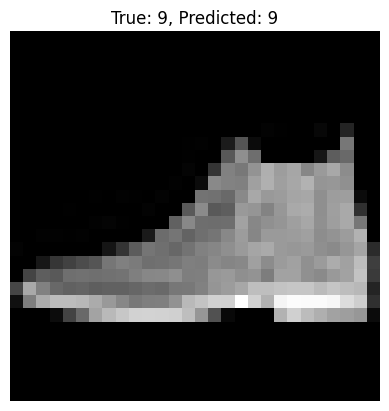

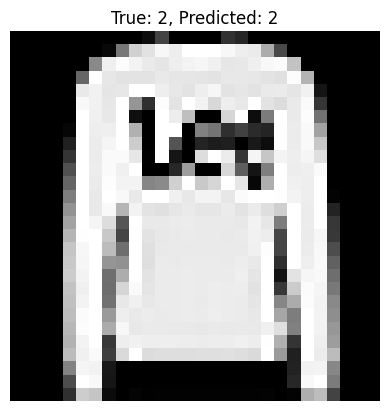

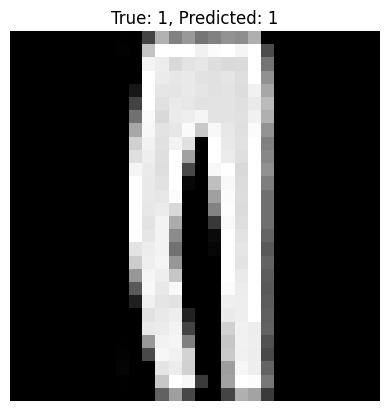

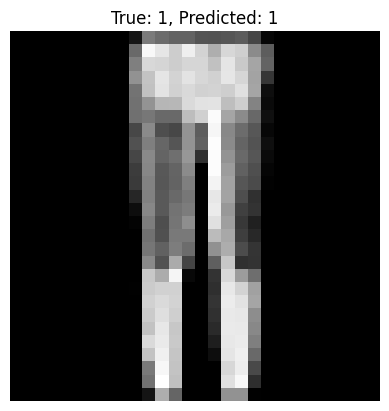

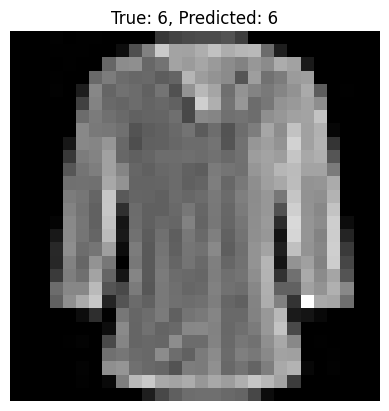

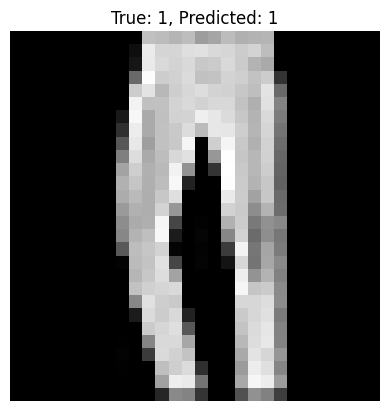

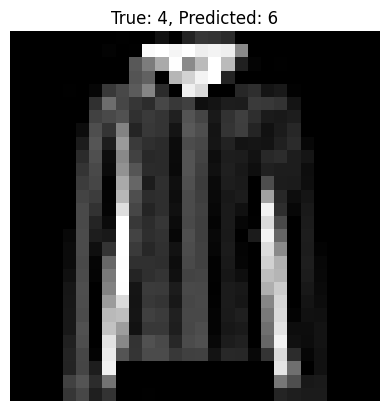

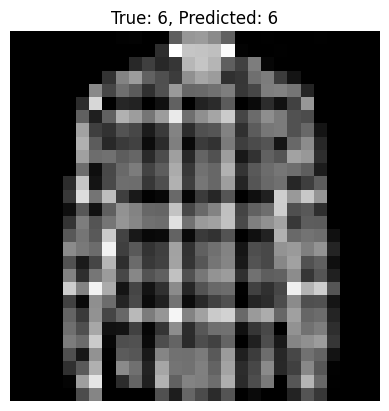

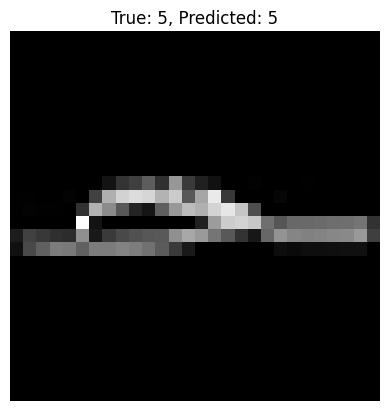

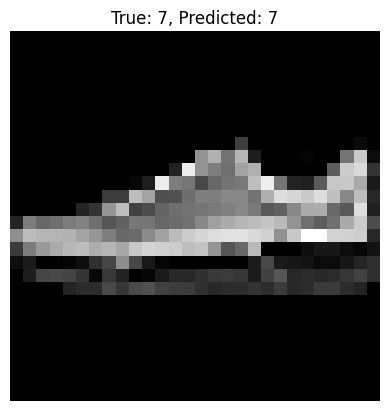


틀린 샘플 번호: [6]


In [7]:
import matplotlib.pyplot as plt

# 데이터셋 로드 (이 부분이 없으면 다시 추가해야 함)
from torchvision import datasets, transforms

# 데이터 변환 정의
mean, std = 0.28604060411453247, 0.3530242443084717
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# 테스트 데이터셋 로드
data_path = "./fashion_mnist_data"
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

# 샘플 10개 고정 선택
sample_indices = list(range(10))  # 첫 10개 샘플 선택
sample_images, sample_labels = zip(*[test_dataset[i] for i in sample_indices])

# 틀린 샘플 추적을 위한 리스트
mismatched_indices = []

# 예측 수행 및 결과 출력
model.eval()
for i in range(10):
    image = sample_images[i].to(device)  # 이미지를 GPU로 전송
    label = sample_labels[i]

    # 모델 예측
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # 배치 차원 추가
        _, predicted = output.max(1)

    # 이미지를 CPU로 다시 이동하여 출력
    plt.imshow(image.cpu().squeeze(), cmap="gray")
    plt.title(f"True: {label}, Predicted: {predicted.item()}")
    plt.axis("off")
    plt.show()

    # 틀린 경우 인덱스 저장
    if label != predicted.item():
        mismatched_indices.append(i)

# 틀린 샘플 번호 출력
if mismatched_indices:
    print(f"\n틀린 샘플 번호: {mismatched_indices}")
else:
    print("\n모든 샘플을 정확히 예측했습니다!")


모델이 코트(4)를 셔츠(6)로 오인했을 가능성이 있습니다

# 숙제 후기

이번 과제를 통해 CNN 모델을 학습시키는 과정에서 데이터 전처리(정규화, 데이터 증강)의 중요성을 이해할 수 있었습니다. Early Stopping로 과적합을 방지하고  Learning Rate 등을 조절해서 학습 속도를 최적화하는 기술을 적용해보니 신기했습니다.

https://wandb.ai/onionring4028-korea-university-of-technology-and-education/fashion_mnist?nw=nwuseronionring4028